In [111]:
print("Вариант:", sum([ord(x) for x in u'Седых']) % 3 + 1)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson

Вариант: 3


In [112]:
class Model:
    def __init__(self, params):
        self.a_min = params['amin']
        self.a_max = params['amax']
        self.b_min = params['bmin']
        self.b_max = params['bmax']
        self.p1 = params['p1']
        self.p2 = params['p2']
        self.p3 = params['p3']
    
    def update_params(self, params):
        self.a_min = params['amin']
        self.a_max = params['amax']
        self.b_min = params['bmin']
        self.b_max = params['bmax']
        self.p1 = params['p1']
        self.p2 = params['p2']
        self.p3 = params['p3']

    def sample_a(self):
        return np.random.uniform(self.a_min, self.a_max)

    def sample_b(self):
        return np.random.uniform(self.b_min, self.b_max)
    
    def sample_c_bin(self, a, b):
        return np.random.binomial(a, self.p1) + np.random.binomial(b, self.p2)
    
    def sample_c_poiss(self, a, b):
        lam = a * self.p1 + b * self.p2
        return np.random.poisson(lam)
    
    def sample_d(self, c):
        return c + np.random.binomial(c, self.p3)
    
    def pmf_c(self, a, b, c_values):
        lam_c = a * self.p1 + b * self.p2
        return poisson.pmf(c_values, lam_c)

    def pmf_d(self, a, b, d_values):
        lam_d = self.p3 * (a * self.p1 + b * self.p2)
        return poisson.pmf(d_values, lam_d)

    def generate(self, N, a, b, params, model):
        self.update_params(params)
        counts = []

        for i in range(N):
            if model == 3:
                c = self.sample_c_bin(a, b)
            elif model == 4:
                c = self.sample_c_poiss(a, b)
            c = np.clip(c, 0, self.a_max + self.b_max)

            d_n = np.random.binomial(c, self.p3)
            d_n = np.clip(d_n, 0, 2 * (self.a_max + self.b_max))

            counts.append(d_n + c)

        return counts

In [66]:
params = {
'amin': 75,
'amax': 90,
'bmin': 500,
'bmax': 600,
'p1': 0.1,
'p2': 0.01,
'p3': 0.3
}

Статистики для Model_1:
              a           b      c_bin    c_poiss      d_bin    d_poiss
mean  82.518035  549.935254  13.692860  13.765390  17.788260  17.888060
std    4.330756   28.825519   3.617631   3.758033   4.988348   5.163481


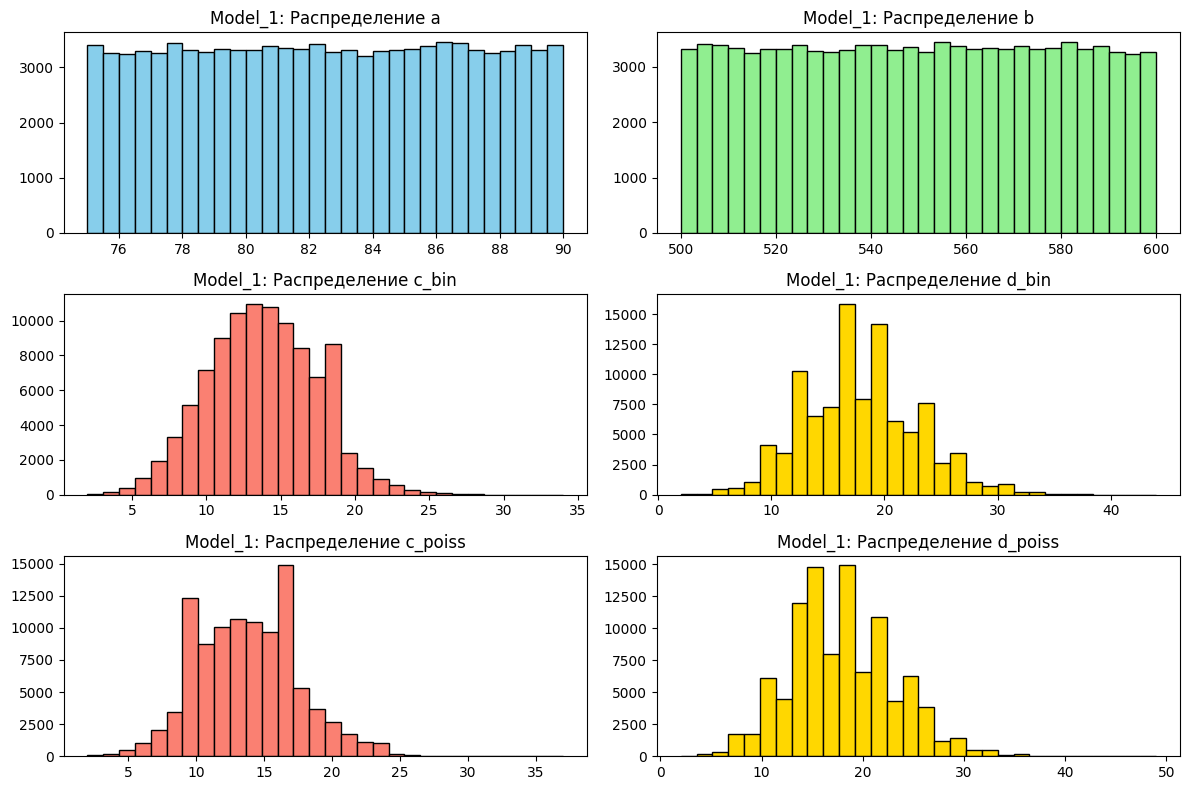

In [67]:
model = Model(params)
COUNT = 100000
rows = []

for _ in range(COUNT):
    a = model.sample_a()
    b = model.sample_b()
    c_bin = model.sample_c_bin(a, b)
    c_poiss = model.sample_c_poiss(a, b)
    d_bin = model.sample_d(c_bin)
    d_poiss = model.sample_d(c_poiss)

    rows.append({
        'a': a,
        'b': b,
        'c_bin': c_bin,
        'c_poiss': c_poiss,
        'd_bin': d_bin,
        'd_poiss': d_poiss
    })

dict_samples = pd.DataFrame(rows)

stats_model = dict_samples.describe().loc[['mean', 'std']]
# Вывод статистик
print("Статистики для Model_1:")
print(stats_model)

# Построение гистограмм
plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
plt.hist(dict_samples['a'], bins=30, color='skyblue', edgecolor='black')
plt.title('Model_1: Распределение a')

plt.subplot(3, 2, 2)
plt.hist(dict_samples['b'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Model_1: Распределение b')

plt.subplot(3, 2, 3)
plt.hist(dict_samples['c_bin'], bins=30, color='salmon', edgecolor='black')
plt.title('Model_1: Распределение c_bin')

plt.subplot(3, 2, 5)
plt.hist(dict_samples['c_poiss'], bins=30, color='salmon', edgecolor='black')
plt.title('Model_1: Распределение c_poiss')

plt.subplot(3, 2, 4)
plt.hist(dict_samples['d_bin'], bins=30, color='gold', edgecolor='black')
plt.title('Model_1: Распределение d_bin')

plt.subplot(3, 2, 6)
plt.hist(dict_samples['d_poiss'], bins=30, color='gold', edgecolor='black')
plt.title('Model_1: Распределение d_poiss')

plt.tight_layout()
plt.show()

In [68]:
import numpy as np
from scipy.stats import poisson

def update_posterior_one_d(d, b_grid, prior, params, known_a=None):
    """
    Обновляет распределение по b на одно наблюдение d.
    prior  – это либо p(b), либо уже p(b|предыдущие d)
    """
    amin, amax = params['amin'], params['amax']
    p1, p2, p3 = params['p1'], params['p2'], params['p3']

    if known_a is not None:
        # a известно
        lam = p3 * (known_a * p1 + b_grid * p2)
        likelihood = poisson.pmf(d, lam)
    else:
        # a неизвестно — усредняем по сетке a
        a_grid = np.arange(amin, amax + 1)
        lam = p3 * (a_grid[:, None] * p1 + b_grid[None, :] * p2)
        like_ab = poisson.pmf(d, lam)
        likelihood = like_ab.mean(axis=0)

    posterior_unnorm = prior * likelihood
    if posterior_unnorm.sum() == 0:
        posterior = np.ones_like(posterior_unnorm, dtype=float)
        posterior /= posterior.sum()
    else:
        posterior = posterior_unnorm / posterior_unnorm.sum()

    return posterior

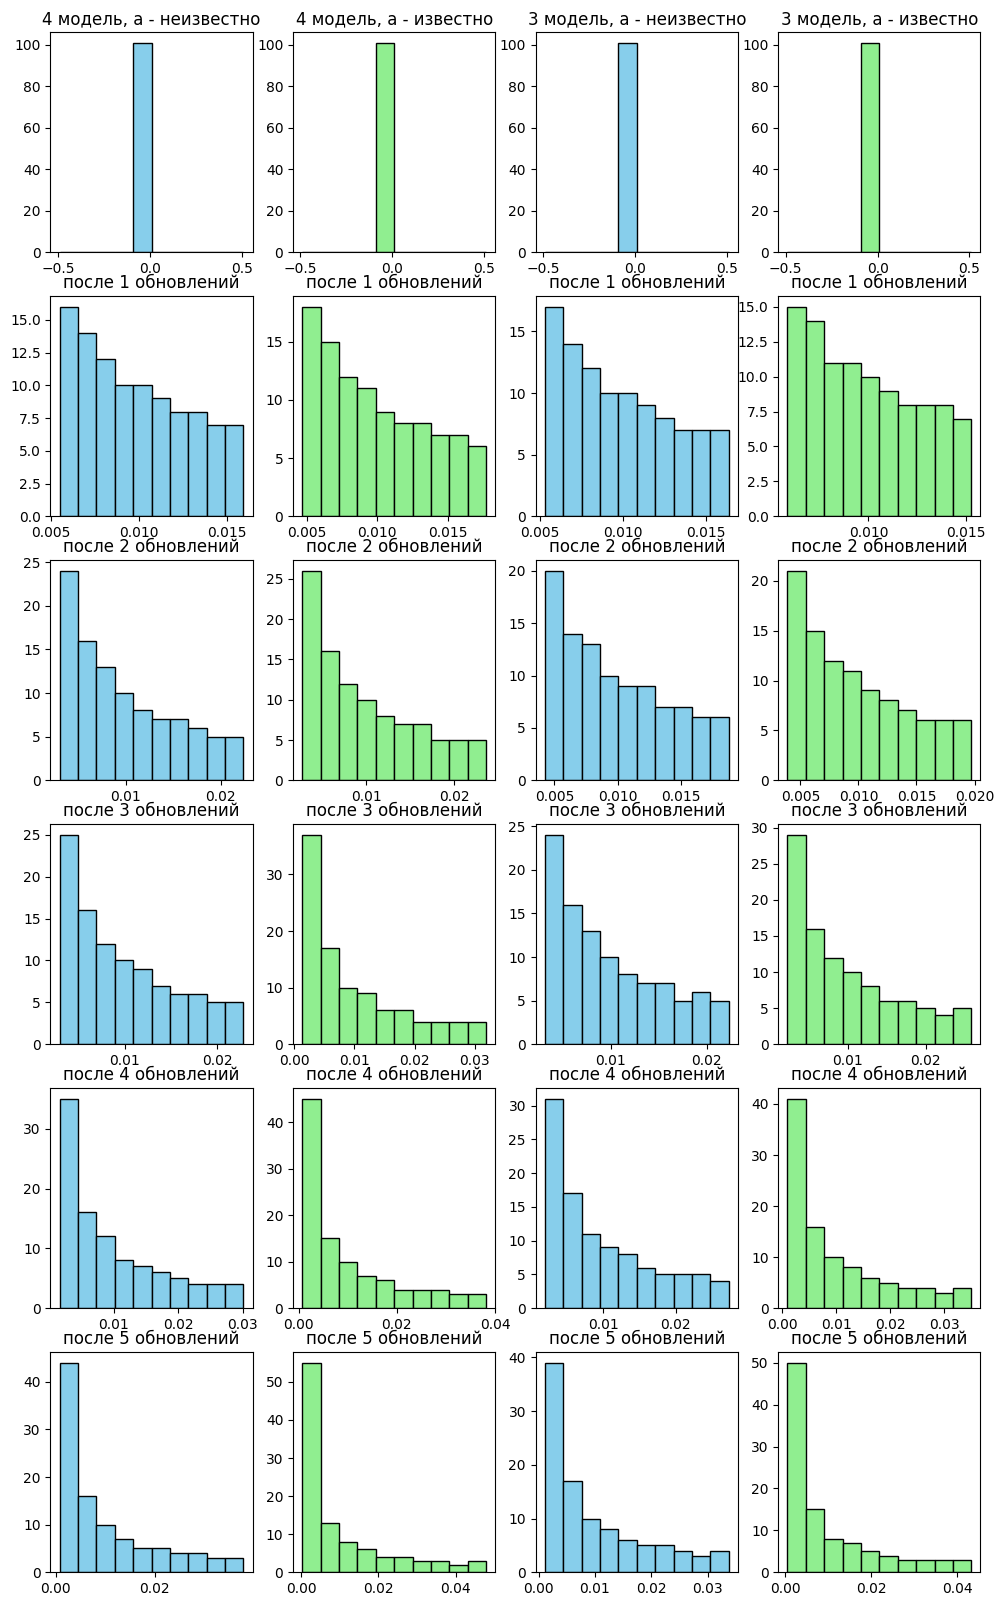

In [104]:
# сетка по b
b_grid = np.arange(params['bmin'], params['bmax'] + 1)

# априор p(b) – равномерный
prior = np.ones_like(b_grid, dtype=float)
prior /= prior.sum()

plt.figure(figsize=(12, 20))

COUNT = 5 # количество обновлений
A = 80
B = 550

# 4 модель, a - неизвестно

plt.subplot(COUNT + 1, 4, 1)
plt.hist(prior, color='skyblue', edgecolor='black')
plt.title('4 модель, a - неизвестно')

model = Model(params)
dn = model.generate(N=COUNT, a=A, b=B, params=params, model=4)

for i in range(COUNT):
    prior = update_posterior_one_d(dn[i], b_grid, prior, params, known_a=None)

    plt.subplot(COUNT + 1, 4, 5 + 4 * i)
    plt.hist(prior, color='skyblue', edgecolor='black')
    plt.title('после {} обновлений'.format(i + 1))

# 4 модель, a - известно

# априор p(b) – равномерный
prior = np.ones_like(b_grid, dtype=float)
prior /= prior.sum()

plt.subplot(COUNT + 1, 4, 2)
plt.hist(prior, color='lightgreen', edgecolor='black')
plt.title('4 модель, a - известно')

model = Model(params)
dn = model.generate(N=COUNT, a=A, b=B, params=params, model=4)

for i in range(COUNT):
    prior = update_posterior_one_d(dn[i], b_grid, prior, params, known_a=A)

    plt.subplot(COUNT + 1, 4, 5 + 4 * i + 1)
    plt.hist(prior, color='lightgreen', edgecolor='black')
    plt.title('после {} обновлений'.format(i + 1))

# 3 модель, a - неизвестно

# априор p(b) – равномерный
prior = np.ones_like(b_grid, dtype=float)
prior /= prior.sum()

plt.subplot(COUNT + 1, 4, 3)
plt.hist(prior, color='skyblue', edgecolor='black')
plt.title('3 модель, a - неизвестно')

model = Model(params)
dn = model.generate(N=COUNT, a=A, b=B, params=params, model=3)

for i in range(COUNT):
    prior = update_posterior_one_d(dn[i], b_grid, prior, params, known_a=None)

    plt.subplot(COUNT + 1, 4, 5 + 4 * i + 2)
    plt.hist(prior, color='skyblue', edgecolor='black')
    plt.title('после {} обновлений'.format(i + 1))

# 3 модель, a - известно

# априор p(b) – равномерный
prior = np.ones_like(b_grid, dtype=float)
prior /= prior.sum()

plt.subplot(COUNT + 1, 4, 4)
plt.hist(prior, color='lightgreen', edgecolor='black')
plt.title('3 модель, a - известно')

model = Model(params)
dn = model.generate(N=COUNT, a=A, b=B, params=params, model=3)

for i in range(COUNT):
    prior = update_posterior_one_d(dn[i], b_grid, prior, params, known_a=A)

    plt.subplot(COUNT + 1, 4, 5 + 4 * i + 3)
    plt.hist(prior, color='lightgreen', edgecolor='black')
    plt.title('после {} обновлений'.format(i + 1))

# Вычислим время

In [105]:
import time

In [123]:
COUNT = 10000
model = Model(params)

a = model.sample_a()
b = model.sample_b()
start = time.time()
for _ in range(COUNT):
    c_bin = model.pmf_c(a, b, np.arange(0, model.a_max + model.b_max + 1))

time1 = time.time() - start
print(f"{COUNT} раз для c: {time1:.4f} секунд")
print(f"На одну выборку приходится {time1 / COUNT:.8f} секунд")


start = time.time()
for _ in range(COUNT):
    d_bin = model.pmf_d(a, b, np.arange(0, 2 * (model.a_max + model.b_max) + 1))

time2 = time.time() - start
print(f"{COUNT} раз для d: {time2:.4f} секунд")
print(f"На одну выборку приходится {time2 / COUNT:.8f} секунд")


start = time.time()
b_grid = np.arange(params['bmin'], params['bmax'] + 1)
A = 80
B = 550
# априор p(b) – равномерный
prior = np.ones_like(b_grid, dtype=float)
prior /= prior.sum()
model = Model(params)
dn = model.generate(N=COUNT, a=A, b=B, params=params, model=3)
for _ in range(COUNT):
    prior = update_posterior_one_d(dn[i], b_grid, prior, params, known_a=None)

time3 = time.time() - start
print(f"{COUNT} раз для p(b|d1, ..., dn): {time3:.4f} секунд")
print(f"На одно обновление приходится {time3 / COUNT:.8f} секунд")


start = time.time()
b_grid = np.arange(params['bmin'], params['bmax'] + 1)
A = 80
B = 550
# априор p(b) – равномерный
prior = np.ones_like(b_grid, dtype=float)
prior /= prior.sum()
model = Model(params)
dn = model.generate(N=COUNT, a=A, b=B, params=params, model=3)
for _ in range(COUNT):
    prior = update_posterior_one_d(dn[i], b_grid, prior, params, known_a=A)

time4 = time.time() - start
print(f"{COUNT} раз для p(b|a, d1, ..., dn): {time4:.4f} секунд")
print(f"На одно обновление приходится {time4 / COUNT:.8f} секунд")

10000 раз для c: 0.6885 секунд
На одну выборку приходится 0.00006885 секунд
10000 раз для d: 1.0778 секунд
На одну выборку приходится 0.00010778 секунд
10000 раз для p(b|d1, ..., dn): 1.1297 секунд
На одно обновление приходится 0.00011297 секунд
10000 раз для p(b|a, d1, ..., dn): 0.5489 секунд
На одно обновление приходится 0.00005489 секунд


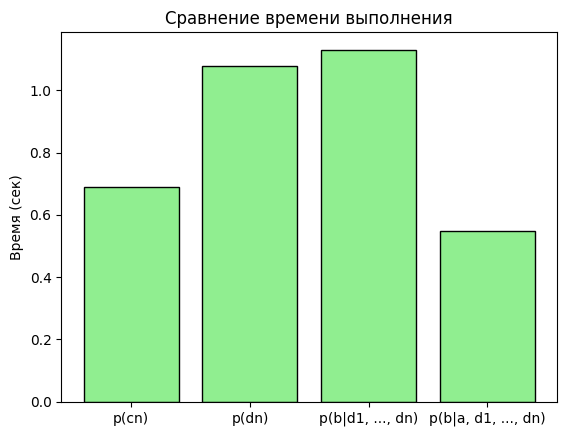

In [124]:
times = [time1, time2, time3, time4]
labels = ['p(cn)', 'p(dn)', 'p(b|d1, ..., dn)', 'p(b|a, d1, ..., dn)']

plt.bar(labels, times, color='lightgreen', edgecolor='black')
plt.ylabel('Время (сек)')
plt.title('Сравнение времени выполнения')
plt.show()